#### Step 1 导入相关包

In [1]:
import pandas as pd
import numpy as np
import json
import re
import torch
import pickle
import json

from tqdm import tqdm
from collections import defaultdict
import pickle
from itertools import combinations

import networkx as nx

#### Step 2 读取pickle和txt数据

In [2]:
# 打开文件
with open('../id2_affiliation_entity_id.pickle', 'rb') as file:
    # 读取文件内容
    id2_affiliation_entity = pickle.load(file)

In [3]:
# 打开文件
with open('../data/zscore_dic.pickle', 'rb') as file:
    # 输入文件内容
    zscore_dict = pickle.load(file)

In [4]:
df_normalized = pd.read_parquet('../data/normalized-ents.parquet')
df_normalized

,ent_id,num,ents
0,0,68935,"[accuracy, Accuracy, accuracies, Acc, ACC, Acc..."
1,1,64046,"[BERT, BERT, BERT model, BERT-base, BERT model..."
2,2,37414,"[F1, F1 score, F-score, F-measure, F 1, F1 sco..."
3,3,26839,"[BLEU, Bleu, bleu, ble, BLEUs, S-BLEU, s-BLEU,..."
4,4,25577,"[precision, Precision, precisions, P @ 1, PR, ..."
...,...,...,...
268387,268387,1,[uniform attention matrix]
268388,268388,1,[UFET task]
268389,268389,1,[rich type ontology]
268390,268390,1,[vanilla curriculum learning]


In [5]:
# 打开文件
with open('../ent-type.txt', 'r') as file:
    # 读取文件内容
    file_contents = file.read()
id_type_json = json.loads(file_contents)

#### Step 3 构建共现关系

In [6]:
# 创建一个 defaultdict 用于存储关键词共现次数
per_year_entity = defaultdict(dict)
for year in range(2000, 2023):
    per_year_entity[year] = defaultdict(list)
    for institution_type in ['academic','industry','cooperation']:
        per_year_entity[year][institution_type] = []

for paper_id in tqdm(id2_affiliation_entity):
    year = id2_affiliation_entity[paper_id]['year']
    cooperation_type = id2_affiliation_entity[paper_id]['Cooperation type']
    ent_list = id2_affiliation_entity[paper_id]['entity']

    temp_lists = []
    # 合并四种实体类型数据
    for entity_type in ['Method','Dataset','Tool','Metric']:
        temp_lists.extend(id2_affiliation_entity[paper_id]['entity'][entity_type])
    try:
        per_year_entity[year][cooperation_type].append(temp_lists)
    except Exception as e:
        print(e)

100%|██████████| 17783/17783 [00:00<00:00, 351778.80it/s]


In [7]:
# 打开文件
with open('../data/per_year_entity.pickle', 'wb') as file:
    # 读取文件内容
    pickle.dump(per_year_entity,file)

In [8]:
per_year_occurrence = defaultdict(dict)
for year in range(2000, 2023):
    per_year_occurrence[year] = defaultdict(dict)
    

for year in tqdm(per_year_entity):
    co_occurrence = defaultdict(int)
    for institution_type in ['industry','academic','cooperation']:
        for entity_list in per_year_entity[year][institution_type]:
            for keyword1, keyword2 in combinations(entity_list, 2):
                co_occurrence[(keyword1, keyword2)] += 1
                
    per_year_occurrence[year]= {key:value for key,value in co_occurrence.items() if value>=2}

100%|██████████| 23/23 [00:05<00:00,  4.15it/s]


In [9]:
zscore_dict[2005]

defaultdict(dict,
            {'academic': {0: 10.711037266050859,
              4: 9.25944205297061,
              5: 9.048300931068027,
              2: 7.477938836917574,
              14: 6.659766989545068,
              28: 5.709631940983449,
              16: 5.300546017297197,
              9: 5.260957056940463,
              53: 4.6407300113516285,
              18: 4.376803608973401,
              63: 4.205251447427553,
              10: 4.099680886476262,
              25: 3.9941103255249715,
              77: 3.9809140054060603,
              62: 3.9809140054060603,
              29: 3.8753434444547694,
              80: 3.6773986426710987,
              41: 3.479453840887428,
              107: 3.373883279936137,
              121: 3.2419200787470235,
              43: 3.004386316606619,
              56: 3.004386316606619,
              27: 2.898815755655328,
              109: 2.7668525544662144,
              3: 2.7404599142283916,
              138: 2.648085673396012,
 

In [10]:
graph_list = defaultdict(dict)
for year in tqdm(per_year_occurrence):
    # 创建一个无向图
    G = nx.Graph()
    # 遍历字典中的每一个键值对，添加边到图中
    for (node1, node2), weight in per_year_occurrence[year].items():
        G.add_node(node1)
        G.add_node(node2)

        # 添加双向边，并将权重加起来
        if G.has_edge(node1, node2):
            G[node1][node2]['weight'] += weight
        else:
            G.add_edge(node1, node2, weight=weight)
    graph_list[year] = G

100%|██████████| 23/23 [00:02<00:00,  9.71it/s]


In [11]:
# 打开文件
with open('../data/graph comp/total_graph_list.pickle', 'wb') as file:
    # 读取文件内容
    pickle.dump(graph_list,file)

In [12]:
# 计算最大连通子图
lists1 = []
for year in range(2000,2023):
    largest_bb = max(nx.connected_components(graph_list[year]), key=len)
    lists1.append(len(largest_bb))
    # 输出最大连通子图的规模
    print(f"{year} 最大连通子图的规模:{len(largest_bb)}" )

2000 最大连通子图的规模:92
2001 最大连通子图的规模:115
2002 最大连通子图的规模:172
2003 最大连通子图的规模:361
2004 最大连通子图的规模:541
2005 最大连通子图的规模:628
2006 最大连通子图的规模:1120
2007 最大连通子图的规模:1113
2008 最大连通子图的规模:931
2009 最大连通子图的规模:1522
2010 最大连通子图的规模:1584
2011 最大连通子图的规模:1567
2012 最大连通子图的规模:1610
2013 最大连通子图的规模:2274
2014 最大连通子图的规模:1935
2015 最大连通子图的规模:2856
2016 最大连通子图的规模:2909
2017 最大连通子图的规模:2647
2018 最大连通子图的规模:4874
2019 最大连通子图的规模:6664
2020 最大连通子图的规模:6745
2021 最大连通子图的规模:9076
2022 最大连通子图的规模:10030


#### Step 4 构造共现网络

In [13]:
per_year_occurrence = defaultdict(dict)
for year in range(2000, 2023):
    per_year_occurrence[year] = defaultdict(dict)
    

for year in tqdm(per_year_entity):
    
    for institution_type in ['industry','academic','cooperation']:
        co_occurrence = defaultdict(int)
        for entity_list in per_year_entity[year][institution_type]:
            for keyword1, keyword2 in combinations(entity_list, 2):
                # if zscore_dict[year][institution_type][keyword1]>0 and zscore_dict[year][institution_type][keyword2]>0:
                co_occurrence[(keyword1, keyword2)] += 1
                
        per_year_occurrence[year][institution_type]= {key:value for key,value in co_occurrence.items() if value>=2}

100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


In [14]:
sub_graph_list = defaultdict(dict)
for year in tqdm(per_year_occurrence):
    sub_graph_list[year] = defaultdict(dict)
    for institution_type in ['industry','academic','cooperation']:
        # 创建一个无向图
        G = nx.Graph()
        # 遍历字典中的每一个键值对，添加边到图中
        for (node1, node2), weight in per_year_occurrence[year][institution_type].items():
            G.add_node(node1)
            G.add_node(node2)

            # 添加双向边，并将权重加起来
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += weight
            else:
                G.add_edge(node1, node2, weight=weight)
        sub_graph_list[year][institution_type] = G

100%|██████████| 23/23 [00:02<00:00, 10.61it/s]


In [15]:
# 打开文件
with open('../data/graph comp/sub_graph_list.pickle', 'wb') as file:
    # 读取文件内容
    pickle.dump(sub_graph_list,file)

In [16]:
# 计算最大连通子图
lists2 = []
for year in range(2000,2023):
    try:
        largest_bb = max(nx.connected_components(sub_graph_list [year]['academic']), key=len)
        lists2.append(len(largest_bb))
        largest_cc = max(nx.connected_components(sub_graph_list [year]['industry']), key=len)
    except Exception as e:
        continue

    # 输出最大连通子图的规模
    print(f"{year} 最大学术界连通子图的规模:{len(largest_bb)}，最大工业界连通子图的规模:{len(largest_cc)}" )

2000 最大学术界连通子图的规模:78，最大工业界连通子图的规模:34
2001 最大学术界连通子图的规模:89，最大工业界连通子图的规模:10
2002 最大学术界连通子图的规模:132，最大工业界连通子图的规模:40
2003 最大学术界连通子图的规模:309，最大工业界连通子图的规模:82
2004 最大学术界连通子图的规模:454，最大工业界连通子图的规模:108
2005 最大学术界连通子图的规模:562，最大工业界连通子图的规模:68
2006 最大学术界连通子图的规模:931，最大工业界连通子图的规模:178
2007 最大学术界连通子图的规模:959，最大工业界连通子图的规模:129
2008 最大学术界连通子图的规模:786，最大工业界连通子图的规模:84
2009 最大学术界连通子图的规模:1295，最大工业界连通子图的规模:179
2010 最大学术界连通子图的规模:1394，最大工业界连通子图的规模:175
2011 最大学术界连通子图的规模:1306，最大工业界连通子图的规模:155
2012 最大学术界连通子图的规模:1320，最大工业界连通子图的规模:107
2013 最大学术界连通子图的规模:1897，最大工业界连通子图的规模:258
2014 最大学术界连通子图的规模:1600，最大工业界连通子图的规模:115
2015 最大学术界连通子图的规模:2432，最大工业界连通子图的规模:230
2016 最大学术界连通子图的规模:2411，最大工业界连通子图的规模:202
2017 最大学术界连通子图的规模:2151，最大工业界连通子图的规模:180
2018 最大学术界连通子图的规模:3747，最大工业界连通子图的规模:556
2019 最大学术界连通子图的规模:4651，最大工业界连通子图的规模:1033
2020 最大学术界连通子图的规模:4463，最大工业界连通子图的规模:1072
2021 最大学术界连通子图的规模:5747，最大工业界连通子图的规模:1309
2022 最大学术界连通子图的规模:5967，最大工业界连通子图的规模:1826


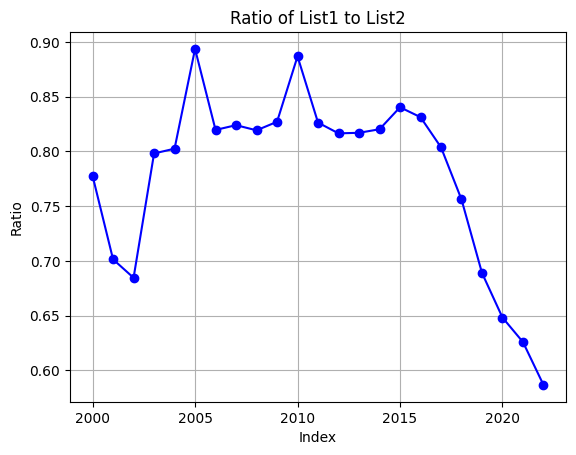

In [72]:
import matplotlib.pyplot as plt

x = range(2000, 2023)
# 计算比值
ratios = [b / a for a, b in zip(lists1, lists2)]

# 绘制折线图
plt.plot(x, ratios, marker='o', linestyle='-', color='b')

# 添加标题和标签
plt.title('Ratio of List1 to List2')
plt.xlabel('Index')
plt.ylabel('Ratio')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

In [11]:
# 打开文件
with open('../data/graph_list.pickle', 'wb') as file:
    # 读取文件内容
    pickle.dump(graph_list,file)

In [116]:
# 获取边的权重信息
top_1_degreee_year = defaultdict(int)
for year in range(2000,2023):
    weights = [d['weight'] for u, v, d in graph_list[year].edges(data=True)]
    # 对列表进行排序
    sorted_data = sorted(weights,reverse=True)
    sorted_data

    # 计前10%的位置
    five_percent_position = int(0.01 * len(sorted_data))

    # 获取前5%的数据
    top_1_percent = sorted_data[five_percent_position]

    top_1_degreee_year[year] = top_1_percent

In [117]:
top_1_degreee_year

defaultdict(int,
            {2000: 4,
             2001: 4,
             2002: 4,
             2003: 5,
             2004: 5,
             2005: 6,
             2006: 6,
             2007: 6,
             2008: 5,
             2009: 6,
             2010: 5,
             2011: 5,
             2012: 5,
             2013: 5,
             2014: 5,
             2015: 6,
             2016: 7,
             2017: 7,
             2018: 9,
             2019: 9,
             2020: 8,
             2021: 8,
             2022: 8})

#### Step 5 查询连边的权重

In [134]:
per_year_edge_describe = defaultdict(dict)
for year in range(2000,2023):
    per_year_edge_describe[year] = defaultdict(list)
    for institution_type in ['academic','industry','cooperation']:
        per_year_edge_describe[year][institution_type] = []

for paper_id in tqdm(id2_affiliation_entity):
    year = id2_affiliation_entity[paper_id]['year']
    cooperation_type = id2_affiliation_entity[paper_id]['Cooperation type']
    ent_list = id2_affiliation_entity[paper_id]['entity']

    G_temp = graph_list[year]

    temp_lists = []
    # 合并四种实体类型数据
    for entity_type in ['Method']:
        temp_lists.extend(id2_affiliation_entity[paper_id]['entity'][entity_type])
    
    weight_lists = []
    for node1, node2 in combinations(temp_lists, 2):
        
        # 添加双向边，并将权重加起来
        if G_temp.has_edge(node1, node2):
            weight = G_temp[node1][node2]['weight']
            weight_lists.append(weight)
            
        else:
            pass
    total_length = len(weight_lists)
    try:
        num = len([degree for degree in weight_lists if degree>=top_1_degreee_year[year]])

        per_year_edge_describe[year][cooperation_type].append(num)
    except Exception as e:
        pass

100%|██████████| 17783/17783 [00:04<00:00, 4232.98it/s]


In [135]:
three_value = defaultdict(list)
for year in range(2000,2023):
    three_value['academic'].append(np.mean(per_year_edge_describe[year]['academic']))
    three_value['industry'].append(np.mean(per_year_edge_describe[year]['industry']))
    three_value['cooperation'].append(np.mean(per_year_edge_describe[year]['cooperation']))

In [136]:
per_year_edge_describe[year]['cooperation']

[0,
 101,
 5,
 0,
 15,
 1,
 23,
 60,
 1,
 6,
 147,
 157,
 249,
 27,
 96,
 12,
 23,
 181,
 76,
 13,
 8,
 120,
 48,
 28,
 119,
 32,
 69,
 22,
 116,
 33,
 142,
 54,
 33,
 80,
 117,
 175,
 45,
 50,
 17,
 66,
 22,
 23,
 179,
 88,
 53,
 61,
 50,
 48,
 28,
 96,
 38,
 266,
 60,
 146,
 168,
 103,
 76,
 49,
 85,
 40,
 41,
 131,
 80,
 134,
 75,
 23,
 35,
 148,
 144,
 97,
 46,
 31,
 38,
 14,
 29,
 126,
 18,
 23,
 15,
 26,
 99,
 42,
 49,
 88,
 108,
 90,
 4,
 248,
 18,
 39,
 30,
 18,
 103,
 116,
 67,
 29,
 56,
 11,
 22,
 159,
 6,
 53,
 96,
 7,
 45,
 132,
 60,
 135,
 64,
 391,
 51,
 55,
 53,
 8,
 115,
 0,
 208,
 28,
 38,
 81,
 18,
 12,
 70,
 9,
 211,
 88,
 4,
 31,
 101,
 23,
 36,
 142,
 21,
 22,
 75,
 26,
 58,
 9,
 16,
 45,
 59,
 17,
 14,
 66,
 37,
 36,
 19,
 152,
 46,
 139,
 75,
 69,
 98,
 58,
 16,
 101,
 12,
 52,
 34,
 34,
 25,
 153,
 19,
 30,
 35,
 27,
 43,
 102,
 104,
 70,
 11,
 35,
 6,
 162,
 86,
 38,
 21,
 163,
 69,
 31,
 66,
 87,
 4,
 8,
 30,
 51,
 102,
 47,
 69,
 50,
 70,
 71,
 30,
 53,
 76,


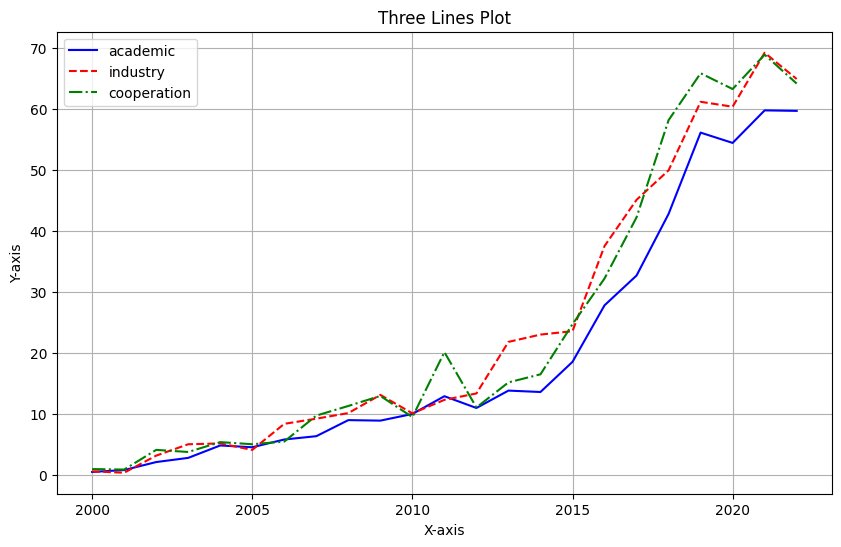

In [137]:
import matplotlib.pyplot as plt

# 创建一些示例数据
x = range(2000,2023)
y1 = three_value['academic']
y2 = three_value['industry']
y3 = three_value['cooperation']

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 画第一个折线图
plt.plot(x, y1, label='academic', color='blue', linestyle='-')

# 画第二个折线图
plt.plot(x, y2, label='industry', color='red', linestyle='--')

# 画第三个折线图
plt.plot(x, y3, label='cooperation', color='green', linestyle='-.')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('Three Lines Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图形
plt.grid(True)
plt.show()
